
# 7-4，DeepFM网络

推荐系统和广告CTR预估主流模型的演化有两条主要路线。

第一条是显式建模特征交互，提升模型对交叉特征的捕获能力。(如Wide&Deep,PNN,FNN,DCN,DeepFM,AutoInt等)

第二条是加入注意力机制，提升模型的自适应能力和解释性。(如DIN,DIEN,DSIN,FiBiNET,AutoInt等)

在所有这些模型中，DeepFM属于性价比非常高的模型（结构简洁，计算高效，指标有竞争力）。

张俊林大佬 在2019年的时候甚至建议 沿着 LR->FM->DeepFM->干点别的 这样的路线去迭代推荐系统。

参考文档：

* 《推荐系统CTR预估学习路线》：https://zhuanlan.zhihu.com/p/351078721 

* criteo数据集榜单：https://paperswithcode.com/dataset/criteo

* DeepFM论文： https://arxiv.org/abs/1703.04247

* 《清晰易懂，基于pytorch的DeepFM的完整实验代码》： https://zhuanlan.zhihu.com/p/332786045

* torch实现参考：https://github.com/rixwew/pytorch-fm/blob/master/torchfm/model/dfm.py

<br>

<font color="red">
 
公众号 **算法美食屋** 回复关键词：**pytorch**， 获取本项目源码和所用数据集百度云盘下载链接。
    
</font> 



In [1]:
import torch 
import torchkeras 
print("torch.__version__ = ", torch.__version__)
print("torchkeras.__version__ = ", torchkeras.__version__) 

torch.__version__ =  2.0.1
torchkeras.__version__ =  3.9.3


## 一，DeepFM原理解析

DeepFM继承了DeepWide的主体结构，将高低特征进行融合。

其主要创新点有2个。

一是将Wide部分替换成了 FM结构，以更有效的捕获特征交互interaction.

二是FM中的隐向量 和 Deep部分的 embedding 向量共享权重，减少模型复杂性。


![](https://tva1.sinaimg.cn/large/e6c9d24egy1h1brqobat6j21260nq0xl.jpg)

## 二，DeepFM的pytorch实现

下面是DeepFM的一个pytorch实现。

除了添加了一个并行的MLP模块用于捕获隐式高阶交叉和组合特征外，其余结构基本和FM的实现完全一致。


In [2]:
import torch 
from torch import nn,Tensor 
import torch.nn.functional as F 

class NumEmbedding(nn.Module):
    """
    连续特征用linear层编码
    输入shape: [batch_size,features_num(n), d_in], # d_in 通常是1
    输出shape: [batch_size,features_num(n), d_out]
    """
    
    def __init__(self, n: int, d_in: int, d_out: int, bias: bool = False) -> None:
        super().__init__()
        self.weight = nn.Parameter(Tensor(n, d_in, d_out))
        self.bias = nn.Parameter(Tensor(n, d_out)) if bias else None
        with torch.no_grad():
            for i in range(n):
                layer = nn.Linear(d_in, d_out)
                self.weight[i] = layer.weight.T
                if self.bias is not None:
                    self.bias[i] = layer.bias

    def forward(self, x_num):
        # x_num: batch_size, features_num, d_in
        assert x_num.ndim == 3
        #x = x_num[..., None] * self.weight[None]
        #x = x.sum(-2)
        x = torch.einsum("bfi,fij->bfj",x_num,self.weight)
        if self.bias is not None:
            x = x + self.bias[None]
        return x
    
class CatEmbedding(nn.Module):
    """
    离散特征用Embedding层编码
    输入shape: [batch_size,features_num], 
    输出shape: [batch_size,features_num, d_embed]
    """
    def __init__(self, categories, d_embed):
        super().__init__()
        self.embedding = torch.nn.Embedding(sum(categories), d_embed)
        self.offsets = nn.Parameter(
                torch.tensor([0] + categories[:-1]).cumsum(0),requires_grad=False)
        
        torch.nn.init.xavier_uniform_(self.embedding.weight.data)

    def forward(self, x_cat):
        """
        :param x_cat: Long tensor of size ``(batch_size, features_num)``
        """
        x = x_cat + self.offsets[None]
        return self.embedding(x) 
    
class CatLinear(nn.Module):
    """
    离散特征用Embedding实现线性层（等价于先F.onehot再nn.Linear()）
    输入shape: [batch_size,features_num], 
    输出shape: [batch_size,features_num, d_out]
    """
    def __init__(self, categories, d_out=1):
        super().__init__()
        self.fc = nn.Embedding(sum(categories), d_out)
        self.bias = nn.Parameter(torch.zeros((d_out,)))
        self.offsets = nn.Parameter(
                torch.tensor([0] + categories[:-1]).cumsum(0),requires_grad=False)

    def forward(self, x_cat):
        """
        :param x: Long tensor of size ``(batch_size, features_num)``
        """
        x = x_cat + self.offsets[None]
        return torch.sum(self.fc(x), dim=1) + self.bias 
    
    
class FMLayer(nn.Module):
    """
    FM交互项
    """

    def __init__(self, reduce_sum=True):
        super().__init__()
        self.reduce_sum = reduce_sum

    def forward(self, x): #注意：这里的x是公式中的 <v_i> * xi
        """
        :param x: Float tensor of size ``(batch_size, num_features, k)``
        """
        square_of_sum = torch.sum(x, dim=1) ** 2
        sum_of_square = torch.sum(x ** 2, dim=1)
        ix = square_of_sum - sum_of_square
        if self.reduce_sum:
            ix = torch.sum(ix, dim=1, keepdim=True)
        return 0.5 * ix
    
    
    
#deep部分
class MultiLayerPerceptron(nn.Module):

    def __init__(self, d_in, d_layers, dropout, 
                 d_out = 1):
        super().__init__()
        layers = []
        for d in d_layers:
            layers.append(nn.Linear(d_in, d))
            layers.append(nn.BatchNorm1d(d))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(p=dropout))
            d_in = d
        layers.append(nn.Linear(d_layers[-1], d_out))
        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        """
        :param x: Float tensor of size ``(batch_size, d_in)``
        """
        return self.mlp(x)
    
    
class DeepFM(nn.Module):
    """
    DeepFM模型。
    """

    def __init__(self, d_numerical, categories, d_embed,
                 deep_layers, deep_dropout,
                 n_classes = 1):
        
        super().__init__()
        if d_numerical is None:
            d_numerical = 0
        if categories is None:
            categories = []
            
        self.categories = categories
        self.n_classes = n_classes
        
        self.num_linear = nn.Linear(d_numerical,n_classes) if d_numerical else None
        self.cat_linear = CatLinear(categories,n_classes) if categories else None
        
        self.num_embedding = NumEmbedding(d_numerical,1,d_embed) if d_numerical else None
        self.cat_embedding = CatEmbedding(categories, d_embed) if categories else None
        
        if n_classes==1:
            self.fm = FMLayer(reduce_sum=True)
            self.fm_linear = None
        else:
            assert n_classes>=2
            self.fm = FMLayer(reduce_sum=False)
            self.fm_linear = nn.Linear(d_embed,n_classes)
            
        self.deep_in = d_numerical*d_embed+len(categories)*d_embed
        
        self.deep = MultiLayerPerceptron(
            d_in= self.deep_in,
            d_layers = deep_layers,
            dropout = deep_dropout,
            d_out = n_classes
        )
        

    def forward(self, x):
        
        """
        x_num: numerical features
        x_cat: category features
        """
        x_num,x_cat = x
        #linear部分
        x = 0.0
        if self.num_linear:
            x = x + self.num_linear(x_num) 
        if self.cat_linear:
            x = x + self.cat_linear(x_cat)
        
        #fm部分
        x_embedding = []
        if self.num_embedding:
            x_embedding.append(self.num_embedding(x_num[...,None]))
        if self.cat_embedding:
            x_embedding.append(self.cat_embedding(x_cat))
        x_embedding = torch.cat(x_embedding,dim=1)
        
        if self.n_classes==1:
            x = x + self.fm(x_embedding)
        else: 
            x = x + self.fm_linear(self.fm(x_embedding)) 
            
        #deep部分
        x = x + self.deep(x_embedding.view(-1,self.deep_in))
        
        if self.n_classes==1:
            x = x.squeeze(-1)
        
        return x

In [3]:
##测试 DeepFM

model = DeepFM(d_numerical = 3, categories = [4,3,2],
        d_embed = 4, deep_layers = [20,20], deep_dropout=0.1,
        n_classes = 1)
x_num = torch.randn(2,3)
x_cat = torch.randint(0,2,(2,3))
model((x_num,x_cat)) 


tensor([-4.4453,  0.1339], grad_fn=<SqueezeBackward1>)

## 三，criteo数据集完整范例

Criteo数据集是一个经典的广告点击率CTR预测数据集。

这个数据集的目标是通过用户特征和广告特征来预测某条广告是否会为用户点击。

数据集有13维数值特征(I1 -> I13)和26维类别特征(C14 -> C39), 共39维特征, 特征中包含着许多缺失值。

训练集4000万个样本，测试集600万个样本。数据集大小超过100G.

此处使用的是采样100万个样本后的cretio_small数据集。 


In [4]:
import numpy as np 
import pandas as pd 
import datetime 

from sklearn.model_selection import train_test_split 

import torch 
from torch import nn 
from torch.utils.data import Dataset,DataLoader  
import torch.nn.functional as F 
import torchkeras 



### 1，准备数据

In [5]:
from sklearn.preprocessing import LabelEncoder,QuantileTransformer
from sklearn.pipeline import Pipeline 
from sklearn.impute import SimpleImputer 

dfdata = pd.read_csv("./eat_pytorch_datasets/criteo_small.zip",sep="\t",header=None)
dfdata.columns = ["label"] + ["I"+str(x) for x in range(1,14)] + [
    "C"+str(x) for x in range(14,40)]

cat_cols = [x for x in dfdata.columns if x.startswith('C')]
num_cols = [x for x in dfdata.columns if x.startswith('I')]
num_pipe = Pipeline(steps = [('impute',SimpleImputer()),('quantile',QuantileTransformer())])

for col in cat_cols:
    dfdata[col]  = LabelEncoder().fit_transform(dfdata[col])

dfdata[num_cols] = num_pipe.fit_transform(dfdata[num_cols])

categories = [dfdata[col].max()+1 for col in cat_cols]


In [6]:
import torch 
from torch.utils.data import Dataset,DataLoader 

#DataFrame转换成torch数据集Dataset, 特征分割成X_num,X_cat方式
class DfDataset(Dataset):
    def __init__(self,df,
                 label_col,
                 num_features,
                 cat_features,
                 categories,
                 is_training=True):
        
        self.X_num = torch.tensor(df[num_features].values).float() if num_features else None
        self.X_cat = torch.tensor(df[cat_features].values).long() if cat_features else None
        self.Y = torch.tensor(df[label_col].values).float() 
        self.categories = categories
        self.is_training = is_training
    
    def __len__(self):
        return len(self.Y)
    
    def __getitem__(self,index):
        if self.is_training:
            return ((self.X_num[index],self.X_cat[index]),self.Y[index])
        else:
            return (self.X_num[index],self.X_cat[index])
    
    def get_categories(self):
        return self.categories
    

In [7]:
dftrain_val,dftest = train_test_split(dfdata,test_size=0.2)
dftrain,dfval = train_test_split(dftrain_val,test_size=0.2)

ds_train = DfDataset(dftrain,label_col = "label",num_features = num_cols,cat_features = cat_cols,
                    categories = categories, is_training=True)

ds_val = DfDataset(dfval,label_col = "label",num_features = num_cols,cat_features = cat_cols,
                    categories = categories, is_training=True)

ds_test = DfDataset(dftest,label_col = "label",num_features = num_cols,cat_features = cat_cols,
                    categories = categories, is_training=True)


In [8]:
dl_train = DataLoader(ds_train,batch_size = 2048,shuffle=True)
dl_val = DataLoader(ds_val,batch_size = 2048,shuffle=False)
dl_test = DataLoader(ds_test,batch_size = 2048,shuffle=False)

for features,labels in dl_train:
    break 
    

### 2，定义模型

In [9]:
def create_net():
    net = DeepFM(
        d_numerical= ds_train.X_num.shape[1],
        categories= ds_train.get_categories(),
        d_embed = 8, deep_layers = [128,64,32], deep_dropout=0.25,
        n_classes = 1
        
    )
    return net 

from torchkeras import summary

net = create_net()
summary(net,input_data=features);


--------------------------------------------------------------------------
Layer (type)                            Output Shape              Param #
Linear-1                                     [-1, 1]                   14
Embedding-2                              [-1, 26, 1]            1,296,709
NumEmbedding-3                           [-1, 13, 8]                  104
Embedding-4                              [-1, 26, 8]           10,373,672
FMLayer-5                                    [-1, 1]                    0
Linear-6                                   [-1, 128]               40,064
BatchNorm1d-7                              [-1, 128]                  256
ReLU-8                                     [-1, 128]                    0
Dropout-9                                  [-1, 128]                    0
Linear-10                                   [-1, 64]                8,256
BatchNorm1d-11                              [-1, 64]                  128
ReLU-12                              

### 3，训练模型

我们使用梦中情炉torchkeras来实现最优雅的训练循环。

In [10]:
from torchkeras.metrics import AUC
from torchkeras import KerasModel 

loss_fn = nn.BCEWithLogitsLoss()

metrics_dict = {"auc":AUC()}

optimizer = torch.optim.Adam(net.parameters(), lr=0.002, weight_decay=0.001) 

model = KerasModel(net,
                   loss_fn = loss_fn,
                   metrics_dict= metrics_dict,
                   optimizer = optimizer
                  )      


<<<<<< 🐌 cpu is used >>>>>>


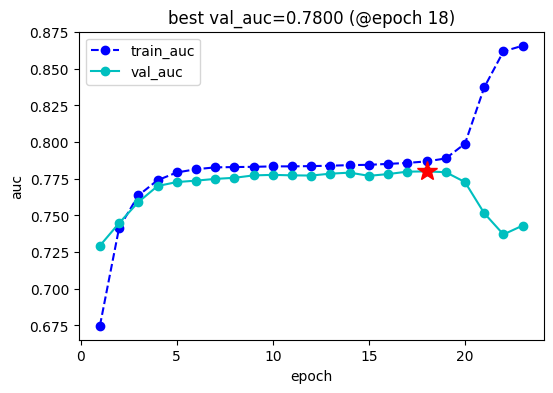

<<<<<< val_auc without improvement in 5 epoch,early stopping >>>>>> 



In [11]:
dfhistory = model.fit(train_data = dl_train,
    val_data = dl_val,
    epochs=100,
    ckpt_path='checkpoint',
    patience=5,
    monitor='val_auc',
    mode='max',
    plot=True,
    cpu=True
)


### 4，评估模型

In [12]:
model.evaluate(dl_test)

100%|████████████████████████████████| 98/98 [00:04<00:00, 23.15it/s, val_auc=0.782, val_loss=0.464]


{'val_loss': 0.4642997295880804, 'val_auc': 0.7817735075950623}

### 5，使用模型

In [13]:
from sklearn.metrics import roc_auc_score
model.eval()
dl_test = model.accelerator.prepare(dl_test)
with torch.no_grad():
    result = torch.cat([model.forward(t[0]) for t in dl_test])

preds = F.sigmoid(result)
labels = torch.cat([x[-1] for x in dl_test])

val_auc = roc_auc_score(labels.numpy(),preds.numpy())
print(val_auc)


0.7817740760992791


### 6，保存模型

模型最佳权重已经保存在 model.fit(ckpt_path) 传入的参数中了。

In [14]:
net_clone = create_net()
net_clone.load_state_dict(torch.load(model.ckpt_path))

<All keys matched successfully>

**如果本书对你有所帮助，想鼓励一下作者，记得给本项目加一颗星星star⭐️，并分享给你的朋友们喔😊!** 

如果对本书内容理解上有需要进一步和作者交流的地方，欢迎在公众号"算法美食屋"下留言。作者时间和精力有限，会酌情予以回复。

也可以在公众号后台回复关键字：**加群**，加入读者交流群和大家讨论。

![算法美食屋logo.png](https://tva1.sinaimg.cn/large/e6c9d24egy1h41m2zugguj20k00b9q46.jpg)